In [ ]:
# Panda Python API
# https://projects.saifsidhik.page/panda_robot/index.html
# ! pip install panda-robot

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import csv
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import joblib
import matplotlib.pyplot as plt
import math


## MPPI-generated dataset

In [3]:
# Data processing with limit filters
filename_input = '/content/states_from_mppi.csv'

input = []
with open(filename_input, mode='r', newline='') as file:
    reader = csv.reader(file)
    headers = next(reader)
    for row in reader:
        input.append([float(r) for r in row])
inputs = [input[i][4:] for i in range(len(input))]
print(len(inputs))
print(len(inputs[0]))
print(inputs[0])


11378
12
[5.245803356170654, 4.483570098876953, 0.309131383895874, -1.6232921495884511e-07, -1.7172726074932143e-05, 2.6944117053062655e-05, 4.6867218017578125, 3.708601236343384, -0.0006153479916974902, 0.06261026859283447, -0.14187613129615784, 0.0013632385525852442]


In [4]:
# Data processing with limit filters
filename_input = '/content/prob_ao_est.csv'
label = []
with open(filename_input, mode='r', newline='') as file:
    reader = csv.reader(file)
    headers = next(reader)
    for row in reader:
        label.append([float(r) for r in row])

success_labels = [label[i][-2] for i in range(len(label))]
maneuver_labels = [label[i][-1] for i in range(len(label))]
print(len(success_labels))
print(success_labels[0])

11378
0.0


In [ ]:
# noninf_idx = []
# for i,l in enumerate(labels):
#     if l != float('inf'): noninf_idx.append(i)

# inputs = [inputs[i] for i in noninf_idx]
# labels = [labels[i] for i in noninf_idx]
# print(len(inputs))
# print(len(labels))

9637
9637


In [ ]:
# inputs = [input[i][4:] for i in range(len(input))]
# filter = [[0.0, 10.0],
#           [0.0, 10.0],
#           [-10.0, 10.0],
#           [-10.0, 10.0],
#           [-20.0, 20.0],
#           [-20.0, 20.0],
#           [-math.pi/2, math.pi/2],
#           [-5.0, 5.0],
#           [-5.0, 5.0],
#           [-math.pi/3, math.pi/3],
#           ]


In [ ]:
# idx = []
# for k, data in enumerate(inputs):
#     bool_list = [(data[i] > filter[i][0] and data[i] < filter[i][1]) for i in range(len(filter))]
#     if False not in bool_list:
#         idx.append(k)
# filtered_inputs = [[count,]+inputs[i] for count, i in enumerate(idx)]
# print(len(filtered_inputs))

14818


In [ ]:
# # Save data to a CSV file with headers
# headers = ['data_id', 'xo', 'yo', 'vxo', 'vyo', 'xg', 'yg', 'thetag', 'vxg', 'vyg', 'omegag']
# filename = 'filtered_states_from_mppi.csv'
# with open(filename, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(headers)
#     writer.writerows(filtered_inputs)

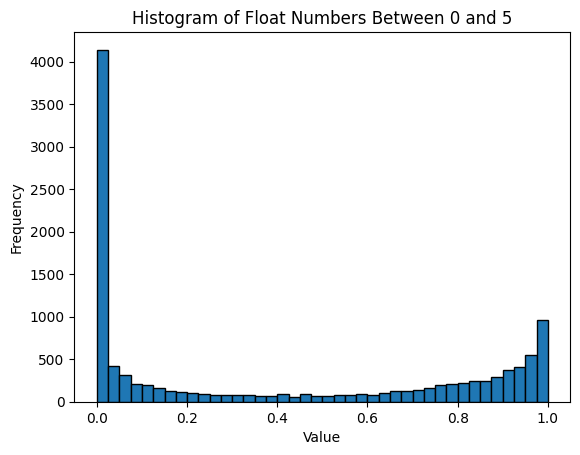

In [7]:
# xo = [inputs[i][0] for i in range(len(inputs))]
# xo = [success_labels[i] for i in range(len(success_labels))]
xo = [maneuver_labels[i] for i in range(len(maneuver_labels))]

# Create the histogram
plt.hist(xo, bins=40, edgecolor='black')  # You can adjust the number of bins

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Float Numbers Between 0 and 5')

# Show the plot
plt.show()

# Initial dataset

In [ ]:
# Data processing
filename_input = 'data_points_O.csv'
filename_label = 'ao_rrt-12s-varyingGoal.csv'

input = [] # 3542
with open(filename_input, mode='r', newline='') as file:
    reader = csv.reader(file)
    headers = next(reader)
    for row in reader:
        input.append([float(r) for r in row])

label = []
with open(filename_label, mode='r', newline='') as file:
    reader = csv.reader(file)
    headers = next(reader)
    for row in reader:
        label.append([float(r) for r in row])

noninf_idx = []
cutoff_hres = 4.5
for i,l in enumerate(label):
    if l[4] != float('inf') and l[4] < cutoff_hres: noninf_idx.append(i)

inputs = [input[i][1:] for i in noninf_idx] # 2802*10
labels = [label[i][-1] for i in noninf_idx] # 2802

In [ ]:
inputs = np.asarray(inputs)
labels = np.asarray(labels)
print(inputs.shape)
print(labels.shape)

(3044, 10)
(3044,)


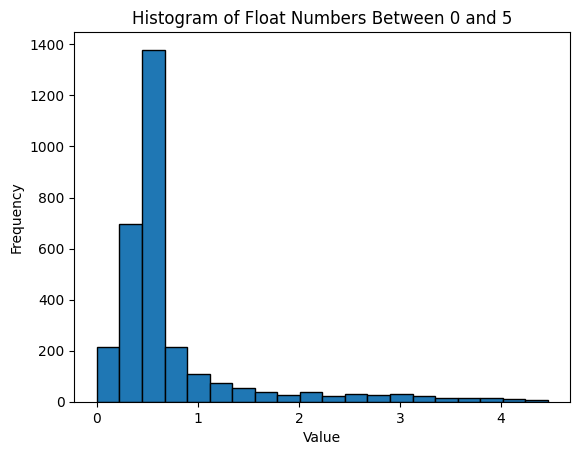

In [ ]:
import matplotlib.pyplot as plt

# Create the histogram
plt.hist(labels, bins=20, edgecolor='black')  # You can adjust the number of bins

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Float Numbers Between 0 and 5')

# Show the plot
plt.show()

# TENSORFLOW

In [ ]:
# Assuming X is your input data and y is your output data
labels = [[s,m] for s,m in zip(success_labels, maneuver_labels)]
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2, random_state=42)

# Min-Max Scaling
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)
joblib.dump(min_max_scaler, 'scaler_minmax.pkl')

# Standardization
standard_scaler = StandardScaler()
X_train_standard = standard_scaler.fit_transform(X_train)
X_test_standard = standard_scaler.transform(X_test)

# # Normalize the data
# scaler = StandardScaler()
# X_train = scaler.fit(X_train)
# X_test = scaler.transform(X_test[:2])

In [ ]:
joblib.dump(min_max_scaler, 'scaler_minmax.pkl')


['scaler_minmax.pkl']

In [ ]:
# # Load the scaler
# scaler0 = joblib.load('my_scaler.pkl')

# # Apply the scaler to new data
# X_new_transformed = scaler0.transform(X_test[:2])
# X_new_transformed

array([[-1.63852813, -0.50929621,  0.08382842, -0.13254498, -1.53643876,
        -0.48864586,  0.00356794,  1.42156081,  0.02362815, -0.37003961],
       [-1.4017682 , -0.41107987, -0.19069578,  0.03995952, -1.37368982,
        -0.38683071,  0.00732365,  1.2256062 ,  0.1998657 ,  0.13719381]])

In [ ]:
# Build the model
hidden_layer_neurals = 64
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(hidden_layer_neurals, activation='relu', input_shape=(10,)),
    tf.keras.layers.Dense(hidden_layer_neurals, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_neurals, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_neurals, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_neurals, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
# Define your desired learning rate
learning_rate = 2e-4
adam_optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# # Train the model
model.fit(X_train_minmax, y_train, validation_split=0.15, epochs=300, batch_size=32, verbose=2)

Epoch 1/300
65/65 - 2s - loss: 0.8649 - val_loss: 0.5981 - 2s/epoch - 35ms/step
Epoch 2/300
65/65 - 0s - loss: 0.5417 - val_loss: 0.5303 - 294ms/epoch - 5ms/step
Epoch 3/300
65/65 - 0s - loss: 0.4823 - val_loss: 0.4703 - 255ms/epoch - 4ms/step
Epoch 4/300
65/65 - 0s - loss: 0.4376 - val_loss: 0.4331 - 250ms/epoch - 4ms/step
Epoch 5/300
65/65 - 0s - loss: 0.4111 - val_loss: 0.4090 - 262ms/epoch - 4ms/step
Epoch 6/300
65/65 - 0s - loss: 0.3882 - val_loss: 0.3820 - 247ms/epoch - 4ms/step
Epoch 7/300
65/65 - 0s - loss: 0.3647 - val_loss: 0.3586 - 251ms/epoch - 4ms/step
Epoch 8/300
65/65 - 0s - loss: 0.3376 - val_loss: 0.3466 - 261ms/epoch - 4ms/step
Epoch 9/300
65/65 - 0s - loss: 0.3149 - val_loss: 0.3181 - 306ms/epoch - 5ms/step
Epoch 10/300
65/65 - 0s - loss: 0.2921 - val_loss: 0.3065 - 258ms/epoch - 4ms/step
Epoch 11/300
65/65 - 0s - loss: 0.2702 - val_loss: 0.3079 - 365ms/epoch - 6ms/step
Epoch 12/300
65/65 - 0s - loss: 0.2528 - val_loss: 0.2541 - 377ms/epoch - 6ms/step
Epoch 13/300
65

In [ ]:
# Evaluate the model

test_loss = model.evaluate(X_test_minmax, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 0.0998


In [ ]:

# Generate predictions
y_pred = model.predict(X_test_minmax)

# Flatten y_pred to ensure it's in the same shape as y_test
y_pred = y_pred.flatten()

# Print true and predicted values
for true, pred in zip(y_test, y_pred):
    print(f"True: {true}, Predicted: {pred}")

20/20 [==============================] - 0s 3ms/step
True: 3.0178682662762513, Predicted: 2.9539005756378174
True: 0.34011344442588587, Predicted: 0.462912380695343
True: 0.4888605092503627, Predicted: 0.46087661385536194
True: 0.5187183288106738, Predicted: 0.5197278261184692
True: 3.839619957911904, Predicted: 4.492387294769287
True: 0.5437148188748948, Predicted: 0.5917494297027588
True: 1.8904210069442406, Predicted: 1.8316186666488647
True: 0.16692362756604606, Predicted: 0.2620367109775543
True: 0.6165579585404503, Predicted: 0.6703601479530334
True: 0.4256696180779985, Predicted: 1.259719967842102
True: 0.2265400860152856, Predicted: -0.07402719557285309
True: 0.3635165964266504, Predicted: 0.457239031791687
True: 3.1286093587060138, Predicted: 3.123720645904541
True: 0.37906718659229477, Predicted: 0.37145134806632996
True: 0.5592932747010888, Predicted: 0.5612027049064636
True: 0.9191880242335625, Predicted: 1.0597026348114014
True: 0.5398662690392555, Predicted: 0.57371300458

In [ ]:
# model.save_weights('cage_metric_model.ckpt')
model.save('model_varyingGoal_cutoffLabels.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the entire model
new_model = load_model('path_to_my_model.h5')

# Use the model for inference
i = (X_test[0:1]).tolist()
print(i)
prediction = new_model.predict(i)
print(prediction)

[[-1.6385281345710567, -0.5092962134283774, 0.08382842145923423, -0.13254497591122066, -1.5364387572726412, -0.4886458616509667, 0.003567941207741127, 1.4215608118319583, 0.023628152616274812, -0.3700396101036746]]
1/1 [==============================] - 0s 234ms/step
[[1.4909074]]


# TORCH

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset


In [91]:
layer_size = 128

# Training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    total_loss = 0
    num_batch = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / batch

def val_loop(dataloader, model, loss_fn):
    num_batch = len(dataloader)
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y.unsqueeze(1))
            total_loss += loss.item()
    return total_loss / num_batch

# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)


In [92]:
# Assuming 'inputs' and 'labels' are your data
# labels = [[s,m] for s,m in zip(success_labels, maneuver_labels)]
labels = success_labels
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.15, random_state=42)

# # Min-Max Scaling
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
joblib.dump(min_max_scaler, 'scaler_minmax.pkl')

# Standardization
# standard_scaler = StandardScaler()
# X_train = standard_scaler.fit_transform(X_train)
# X_test = standard_scaler.transform(X_test)
# joblib.dump(min_max_scaler, 'scaler_standard.pkl')


['scaler_minmax.pkl']

In [93]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # 0.25 x 0.8 = 0.2

# Convert arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = NeuralNetwork()

# Define the optimizer and loss function
learning_rate = 3e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()


In [94]:
train_losses = []
val_losses = []
epochs = 50
for epoch in range(epochs):
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    val_loss = val_loop(val_loader, model, loss_fn)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}\n-------------------------------")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}\n")

Epoch 1
-------------------------------
Training Loss: 0.1227
Validation Loss: 0.1010

Epoch 2
-------------------------------
Training Loss: 0.0720
Validation Loss: 0.0582

Epoch 3
-------------------------------
Training Loss: 0.0503
Validation Loss: 0.0487

Epoch 4
-------------------------------
Training Loss: 0.0421
Validation Loss: 0.0404

Epoch 5
-------------------------------
Training Loss: 0.0356
Validation Loss: 0.0342

Epoch 6
-------------------------------
Training Loss: 0.0301
Validation Loss: 0.0290

Epoch 7
-------------------------------
Training Loss: 0.0259
Validation Loss: 0.0253

Epoch 8
-------------------------------
Training Loss: 0.0229
Validation Loss: 0.0225

Epoch 9
-------------------------------
Training Loss: 0.0205
Validation Loss: 0.0202

Epoch 10
-------------------------------
Training Loss: 0.0185
Validation Loss: 0.0186

Epoch 11
-------------------------------
Training Loss: 0.0170
Validation Loss: 0.0176

Epoch 12
-------------------------------


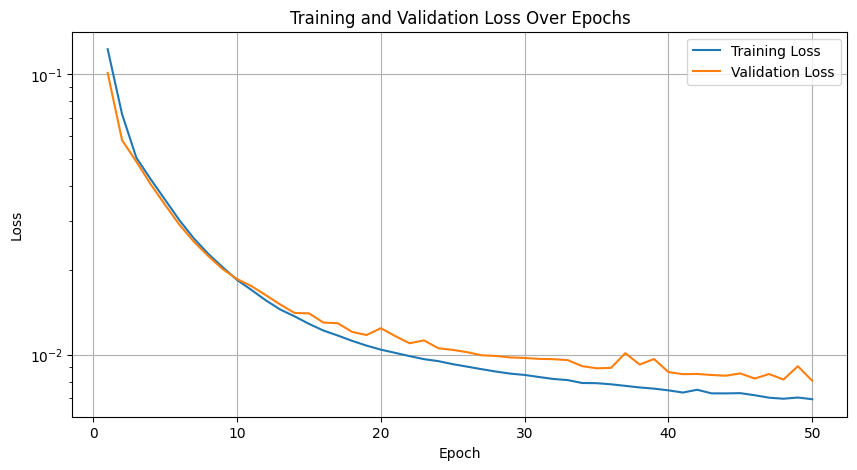

In [95]:
# Create a plot of training and validation losses
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
ax.set_yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [96]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor).item()
    print(f"Test Loss: {test_loss}")

# Save the model
torch.save(model.state_dict(), 'model_11k.pth')

Test Loss: 0.2334563136100769


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1707])) that is different to the input size (torch.Size([1707, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [99]:
# Print true and predicted values
for true, pred in zip(y_test[:100], y_pred.tolist()[:100]):
    print(f"True: {true}, Predicted: {pred}")

True: 0.09501648334557618, Predicted: [0.12087370455265045]
True: 1.1702300156168265e-11, Predicted: [-0.010196041315793991]
True: 0.0, Predicted: [-0.0067215003073215485]
True: 4.720007476675832e-05, Predicted: [-0.003118019551038742]
True: 0.023287717772783965, Predicted: [0.03565071150660515]
True: 0.0, Predicted: [-0.051439907401800156]
True: 0.0, Predicted: [-0.018868248909711838]
True: 0.0, Predicted: [-0.00734793022274971]
True: 4.03199003735671e-11, Predicted: [-0.008567478507757187]
True: 3.821138289710384e-08, Predicted: [-0.007883157581090927]
True: 0.763437781905207, Predicted: [0.5751135349273682]
True: 0.0, Predicted: [-0.005150366574525833]
True: 0.5044446776319355, Predicted: [0.4770084619522095]
True: 7.440086685681769e-09, Predicted: [-0.033794548362493515]
True: 0.04272308665047889, Predicted: [0.11257430911064148]
True: 0.3059998462526766, Predicted: [0.10276058316230774]
True: 0.0, Predicted: [0.04548525810241699]
True: 0.08782566794397852, Predicted: [0.0241278521

# 2D Output Torch

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib

# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output layer for 2D output
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

# Assuming 'inputs' and 'labels' are your data
# labels should be a list of lists with 2 elements each, for example: [[output1, output2], ...]

# Split the data into training, validation, and test sets
labels = [[s,m] for s,m in zip(success_labels, maneuver_labels)]
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Min-Max Scaling
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
X_val = min_max_scaler.transform(X_val)
joblib.dump(min_max_scaler, 'scaler_minmax.pkl')

# Convert arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = NeuralNetwork()

# Define the optimizer and loss function
learning_rate = 1e-4  # Adjusted learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()  # Mean Squared Error Loss for regression

# Training and validation loops
def train_loop(dataloader, model, loss_fn, optimizer):
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def val_loop(dataloader, model, loss_fn):
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()

    return total_loss / len(dataloader)

# Training process
epochs = 100
for epoch in range(epochs):
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    val_loss = val_loop(val_loader, model, loss_fn)
    print(f"Epoch {epoch+1}\n-------------------------------")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor).item()
    print(f"Test Loss: {test_loss}")

# Save the model
torch.save(model.state_dict(), 'model_12d_2d_outputs.pth')

Epoch 1
-------------------------------
Training Loss: 0.1810
Validation Loss: 0.1279
Epoch 2
-------------------------------
Training Loss: 0.1146
Validation Loss: 0.1066
Epoch 3
-------------------------------
Training Loss: 0.1004
Validation Loss: 0.0978
Epoch 4
-------------------------------
Training Loss: 0.0941
Validation Loss: 0.0926
Epoch 5
-------------------------------
Training Loss: 0.0901
Validation Loss: 0.0891
Epoch 6
-------------------------------
Training Loss: 0.0872
Validation Loss: 0.0863
Epoch 7
-------------------------------
Training Loss: 0.0847
Validation Loss: 0.0848
Epoch 8
-------------------------------
Training Loss: 0.0827
Validation Loss: 0.0826
Epoch 9
-------------------------------
Training Loss: 0.0810
Validation Loss: 0.0810
Epoch 10
-------------------------------
Training Loss: 0.0792
Validation Loss: 0.0793
Epoch 11
-------------------------------
Training Loss: 0.0775
Validation Loss: 0.0774
Epoch 12
-------------------------------
Training Lo

In [101]:
# Print true and predicted values
for true, pred in zip(y_test[:100], y_pred.tolist()[:100]):
    print(f"True: {true}, Predicted: {pred}")

True: [0.09501648334557618, 0.0012889564494493744], Predicted: [0.15320418775081635, 0.07646520435810089]
True: [1.1702300156168265e-11, 3.317802932389924e-06], Predicted: [0.015720367431640625, -0.14048835635185242]
True: [0.0, 0.019683619611884917], Predicted: [0.006691277027130127, 0.03609835356473923]
True: [4.720007476675832e-05, 0.9631333004290005], Predicted: [0.004870429635047913, 0.8843719959259033]
True: [0.023287717772783965, 0.0001713807219289043], Predicted: [0.075232595205307, -0.1660510152578354]
True: [0.0, 0.0012074386599433273], Predicted: [-0.029554422944784164, 0.050232455134391785]
True: [0.0, 0.024980503732990877], Predicted: [0.018257275223731995, 0.5167405009269714]
True: [0.0, 0.9374072105461859], Predicted: [-0.013145670294761658, 0.5447877645492554]
True: [4.03199003735671e-11, 0.9373963963658175], Predicted: [0.00012404471635818481, 0.5831563472747803]
True: [3.821138289710384e-08, 0.7571510999348037], Predicted: [-0.004897505044937134, 0.5815176963806152]
T